In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 
from datetime import datetime
from scipy.optimize import minimize
import yfinance as yf

Considérons dans un premier temps le cas d’un marché financier composé uniquement d’actifs risqués, l’univers d’investissement contient `n_assets` titres financiers risqués.


In [2]:
tickers  = ['V','PG',"JNJ","WMT","VZ","NEE",'KO','MSFT']
n_assets = len(tickers)
stocks   = yf.download(tickers)['Adj Close']['2021':]
stocks.dropna(inplace=True)

[*********************100%%**********************]  8 of 8 completed


<Axes: xlabel='Date'>

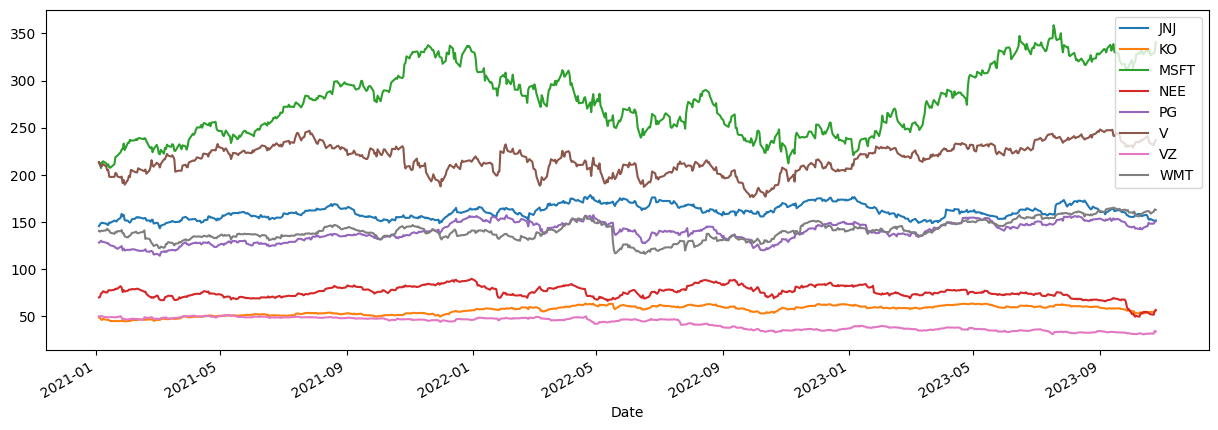

In [3]:
stocks.plot(figsize=(15,5))


Nous adaptons les notations suivantes :

  - $\boldsymbol{w} \in \mathbb{R}^{n\times 1}$ : un vecteur représentant les poids d'un portefeuille $P$.
  - $\boldsymbol{R} \in \mathbb{R}^{n\times 1}$ : un vecteur représentant les rentabilités aléatoires des actifs financiers de l'univers d'investissement. $\mathbb{E}[\boldsymbol{R}]$ désigne son espérance.
  - $\boldsymbol{e} \in \mathbb{R}^{n\times 1}$ : un vecteur dont toutes les composantes sont égales à $1$.
  - $V \in \mathbb{M}_n(\mathbb{R})$ : la matrice des variances-covariances des rentabilités des actifs financiers. On suppose que cette matrice est inversible.
$\sigma_i^2 = \sigma^2_i = \sigma^2(R_i)$ : variance de la rentabilité du $i$-ème actif financier.
$\sigma_{ij} = \text{Cov}(R_i, R_j)$ : covariance entre le taux de rendement du $i$-ème actif financier et le taux de rendement du $j$-ème actif financier.

En notation matricielle :
$$
\boldsymbol{w} =
\begin{pmatrix}
w_1 \\
\vdots \\
w_N
\end{pmatrix}, \quad
\mathbb{E}[\boldsymbol{R}] =
\begin{pmatrix}
\mathbb{E}[R_1] \\
\vdots \\
\mathbb{E}[R_N]
\end{pmatrix}, \quad
\boldsymbol{e} =
\begin{pmatrix}
1 \\
\vdots \\
1
\end{pmatrix}, \quad
\boldsymbol{V} =
\begin{pmatrix}
\sigma_{11} & \cdots & \sigma_{1N} \\
\vdots & \ddots & \vdots \\
\sigma_{N1} & \cdots & \sigma_{NN}
\end{pmatrix}
$$

Il faut également noter que notre matrice des variances-covariances est symétrique, c’est-à-dire que $V = V^T$.

Il s’agit d’obtenir l’ensemble des portefeuilles qui, pour chaque niveau donné d’espérance de rentabilité, ont une variance minimale. De façon alternative, on peut chercher l’ensemble des portefeuilles qui, pour chaque niveau donné de variance, exhibent l’espérance de rentabilité maximale.


# statistiques des actifs

## Rendements

In [4]:
def compute_returns(s):
    '''
    Computes the returns (percentage change) of a Dataframe of Series. 
    In the former case, it computes the returns for every column (Series) by using pd.aggregate
    '''
    if isinstance(s, pd.DataFrame):
        return s.aggregate( compute_returns )
    elif isinstance(s, pd.Series):
        return s / s.shift(1) - 1
    else:
        raise TypeError("Expected pd.DataFrame or pd.Series")

In [5]:
# compute the daily returns 
daily_rets = compute_returns(stocks)
daily_rets#.tail()

,JNJ,KO,MSFT,NEE,PG,V,VZ,WMT
Date,,,,,,,,
2021-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05,0.011757,-0.010993,0.000965,0.007410,0.006385,-0.014924,-0.004588,-0.005323
2021-01-06,0.009410,-0.031813,-0.025929,0.048950,0.010527,-0.008811,0.012120,0.006244
2021-01-07,0.003378,-0.011085,0.028457,0.010965,-0.009347,0.005597,-0.002250,-0.000068
2021-01-08,-0.002058,0.022418,0.006093,0.023206,-0.000432,0.007670,-0.012472,-0.000136
...,...,...,...,...,...,...,...,...
2023-10-19,-0.002684,0.005550,0.003666,-0.015965,-0.005628,-0.015412,0.017069,-0.004767
2023-10-20,0.004464,0.004048,-0.014035,-0.008208,-0.001349,-0.001839,-0.000317,-0.012502
2023-10-23,-0.010523,-0.008979,0.008112,-0.008468,0.000675,-0.007927,-0.005702,0.014172


## Rendements annualisés 

In [6]:
def annualize_rets(s, periods_per_year):
    '''
    Computes the return per year, or, annualized return.
    The variable periods_per_year can be, e.g., 12, 52, 252, in 
    case of monthly, weekly, and daily data.
    The method takes in input either a DataFrame or a Series and, in the former 
    case, it computes the annualized return for every column (Series) by using pd.aggregate
    '''
    if isinstance(s, pd.DataFrame):
        return s.aggregate( annualize_rets, periods_per_year=periods_per_year )
    elif isinstance(s, pd.Series):
        growth = (1 + s).prod()
        n_period_growth = s.shape[0]
        return growth**(periods_per_year/n_period_growth) - 1

In [7]:
# Annualize returns (periods = 252)
ann_rets = annualize_rets(daily_rets, 252)
round(ann_rets,2)

JNJ     0.01
KO      0.05
MSFT    0.18
NEE    -0.07
PG      0.06
V       0.04
VZ     -0.13
WMT     0.05
dtype: float64

## Volatilité annualisés

In [8]:
def annualize_vol(s, periods_per_year, ddof=1):
    '''
    Computes the volatility per year, or, annualized volatility.
    The variable periods_per_year can be, e.g., 12, 52, 252, in 
    case of monthly, weekly, and daily data.
    The method takes in input either a DataFrame, a Series, a list or a single number. 
    In the former case, it computes the annualized volatility of every column 
    (Series) by using pd.aggregate. In the latter case, s is a volatility 
    computed beforehand, hence only annulization is done
    '''
    if isinstance(s, pd.DataFrame):
        return s.aggregate(annualize_vol, periods_per_year=periods_per_year )
    elif isinstance(s, pd.Series):
        return s.std(ddof=ddof) * (periods_per_year)**(0.5)
    elif isinstance(s, list):
        return np.std(s, ddof=ddof) * (periods_per_year)**(0.5)
    elif isinstance(s, (int,float)):
        return s * (periods_per_year)**(0.5)

La variance de la rentabilité du portefeuille $P$ est donnée par l’expression :

$$
\sigma^2(R_P) = \boldsymbol{w}^T \boldsymbol{V} \boldsymbol{w}.
$$

In [9]:
def portfolio_volatility(cov_returns,weights,periods_per_year=252): 
    return annualize_vol((weights.T @ cov_returns @ weights)**(0.5),periods_per_year)

## Portefeuille

In [10]:
def portfolio_return(weights, vec_returns):
    '''
    Computes the return of a portfolio. 
    It takes in input a row vector of weights (list of np.array) 
    and a column vector (or pd.Series) of returns
    '''
    return np.dot(weights, vec_returns)
    
def portfolio_volatility(weights, cov_rets):
    '''
    Computes the volatility of a portfolio. 
    It takes in input a vector of weights (np.array or pd.Series) 
    and the covariance matrix of the portfolio asset returns
    '''
    return ( np.dot(weights.T, np.dot(cov_rets, weights)) )**(0.5) 



In [11]:
# compute the mean daily returns and the covariance of daily returns of the two assets
mean_rets = daily_rets.mean()
std_rets  = daily_rets.std()
cov_rets  = daily_rets.cov()
cov_rets

,JNJ,KO,MSFT,NEE,PG,V,VZ,WMT
JNJ,0.000105,0.000050,0.000037,0.000052,0.000058,0.000040,0.000037,0.000042
KO,0.000050,0.000108,0.000064,0.000071,0.000078,0.000067,0.000048,0.000054
MSFT,0.000037,0.000064,0.000317,0.000111,0.000063,0.000140,0.000031,0.000060
NEE,0.000052,0.000071,0.000111,0.000294,0.000080,0.000069,0.000070,0.000063
PG,0.000058,0.000078,0.000063,0.000080,0.000121,0.000060,0.000052,0.000058
V,0.000040,0.000067,0.000140,0.000069,0.000060,0.000246,0.000048,0.000039
VZ,0.000037,0.000048,0.000031,0.000070,0.000052,0.000048,0.000166,0.000038
WMT,0.000042,0.000054,0.000060,0.000063,0.000058,0.000039,0.000038,0.000160


In [18]:
E_R=mean_rets
V=cov_rets

In [19]:
weights=np.repeat(1/n_assets, n_assets)
portfolio_volatility(V,weights)

array([0.00017498, 0.00020401, 0.00026986, 0.00026259, 0.00020943,
       0.00024418, 0.00018976, 0.00019646])

### Portefeuille de variance minimale


La première question que se pose un investisseur est évidemment de savoir : quel portefeuille efficient offre le niveau de risque le plus faible ? Il s’agit d’optimiser le programme quadratique suivant :


\begin{cases}
    \min(\boldsymbol{w}^T \boldsymbol{V} \boldsymbol{w}) \\
    \text{s.c. } \boldsymbol{w}^T \boldsymbol{e} = 1
\end{cases}


La contrainte est simplement une contrainte de budget indiquant que la somme des poids est égale à 1, c’est-à-dire 100\%.



### Portefeuille efficient

Un portefeuille efficient est un portefeuille dont la rentabilité moyenne est maximale pour un niveau de risque donné, ou dont le risque est minimal pour une rentabilité donnée. Les portefeuilles efficaces sont sur la « frontière efficiente » de l’ensemble des portefeuilles dans le plan $(\sigma^2_p, E[P])$.

Notre objectif est de pouvoir déterminer cette frontière efficiente ou du moins exprimer une fonction qui permet de déterminer le portefeuille pour un niveau de rendement cible $E_0$. Ce problème peut se formuler comme ci-dessous :

$$
\begin{cases}
    \min(\boldsymbol{w}^T \boldsymbol{V} \boldsymbol{w}) \\
    \text{s.c. } \boldsymbol{w}^T \mathbb{E}[\boldsymbol{R}] = E_0 \\
    \boldsymbol{w}^T \boldsymbol{e} = 1
\end{cases}
$$

La première contrainte porte sur la rentabilité espérée du portefeuille alors que la seconde est simplement une contrainte de budget indiquant que la somme des poids est égale à 1, c’est-à-dire 100\%.


In [20]:
def minimize_volatility(rets, covmatrix, target_return=None):

    n_assets = rets.shape[0]    
    # initial guess weights
    init_guess = np.repeat(1/n_assets, n_assets)
    weights_constraint = {
        "type": "eq",
        "fun": lambda w: 1.0 - np.sum(w)  
    }
    if target_return is not None:
        return_constraint = {
            "type": "eq",
            "args": (rets,),
            "fun": lambda w, r: target_return - portfolio_return(w, r)
        }
        constr = (return_constraint, weights_constraint)
    else:
        constr = weights_constraint
        
    result = minimize(portfolio_volatility, 
                      init_guess,
                      args = (covmatrix,),
                      method = "SLSQP",
                      options = {"disp": False},
                      constraints = constr,
                      bounds = ((0.0,1.0),)*n_assets ) # bounds of each individual weight, i.e., w between 0 and 1
    return result.x

In [21]:
minimize_volatility(E_R,V)

array([3.28192535e-01, 1.63268908e-01, 4.40976546e-02, 3.46944695e-18,
       7.72010537e-02, 4.86609064e-02, 1.78588292e-01, 1.59990649e-01])

In [22]:
(minimize_volatility(E_R,V,target_return=0.2))

array([1.64805646e-14, 9.00932039e-13, 1.00000000e+00, 2.68980995e-16,
       9.06834100e-13, 9.52535138e-13, 5.19590649e-16, 1.13323496e-12])

## simulation des portefeuilles

Now we simulate $4000$ portfolios with weights allocated to the stocks above:

In [23]:
periods_per_year = 252
num_portfolios   = 4000
portfolios       = pd.DataFrame(columns=["return","volatility"]+[f'w{i}' for i in range(1,n_assets+1)])


In [24]:
for i in range(num_portfolios):
    # select random weights
    weights = np.random.random(n_assets)
    # and rescale them to sum to 1
    weights /= np.sum(weights)
    
    # annualized portfolio returns
    #ann_rets      = annualize_rets(daily_rets, periods_per_year)
    portfolio_ret = portfolio_return(weights, ann_rets)        

    # annualized portfolio volatility
    portfolio_vol = portfolio_volatility(weights, cov_rets)
    portfolio_vol = annualize_vol(portfolio_vol, periods_per_year)

    portfolios.loc[i]=[portfolio_ret,portfolio_vol]+ [weights[i-1] for i in range(1,n_assets+1)]
    

In [25]:
portfolios.tail()

,return,volatility,w1,w2,w3,w4,w5,w6,w7,w8
3995,0.043576,0.143556,0.158013,0.139391,0.162289,0.152861,0.212282,0.053757,0.032301,0.089105
3996,0.054868,0.152561,0.064465,0.157860,0.200318,0.116662,0.055562,0.198817,0.024614,0.181702
3997,0.018990,0.149404,0.049946,0.204031,0.011862,0.228047,0.304911,0.111793,0.028958,0.060453
3998,0.036933,0.131400,0.255326,0.223269,0.119358,0.011507,0.199366,0.011276,0.118290,0.061609
3999,0.015815,0.130287,0.241690,0.005779,0.039523,0.034676,0.171455,0.108242,0.155773,0.242861


In [26]:
def optimal_weights(n_points, rets, covmatrix, periods_per_year):
    '''
    Returns a set of n_points optimal weights corresponding to portfolios (of the efficient frontier) 
    with minimum volatility constructed by fixing n_points target returns. 
    The weights are obtained by solving the minimization problem for the volatility. 
    '''
    target_rets = np.linspace(rets.min(), rets.max(), n_points)    
    weights = [minimize_volatility(rets, covmatrix, target) for target in target_rets]
    return weights

In [27]:
def efficient_frontier(n_portfolios, rets, covmat, periods_per_year):
    '''
    Returns (and plots) the efficient frontiers for a portfolio of rets.shape[1] assets. 
    The method returns a dataframe containing the volatilities, returns, sharpe ratios and weights 
    of the portfolios as well as a plot of the efficient frontier in case iplot=True. 
    Other inputs are:
        hsr: if true the method plots the highest return portfolio,
        cml: if True the method plots the capital market line;
        mvp: if True the method plots the minimum volatility portfolio;
        ewp: if True the method plots the equally weigthed portfolio. 
    The variable periods_per_year can be, e.g., 12, 52, 252, in case of monthly, weekly, and daily data.
    '''   
    

        
    ann_rets = annualize_rets(rets, periods_per_year)
    
    # generates optimal weights of porfolios lying of the efficient frontiers
    weights = optimal_weights(n_portfolios, ann_rets, covmat, periods_per_year) 
    # in alternative, if only the portfolio consists of only two assets, the weights can be: 
    #weights = [np.array([w,1-w]) for w in np.linspace(0,1,n_portfolios)]

    # portfolio returns
    portfolio_ret = [portfolio_return(w, ann_rets) for w in weights]
    
    # portfolio volatility
    vols          = [portfolio_volatility(w, covmat) for w in weights] 
    portfolio_vol = [annualize_vol(v, periods_per_year) for v in vols]
    
    # portfolio sharpe ratio
    
    df = pd.DataFrame({"volatility": portfolio_vol,
                       "return": portfolio_ret
                       })
    df = pd.concat([df, pd.DataFrame(weights)],axis=1)
    
    return df

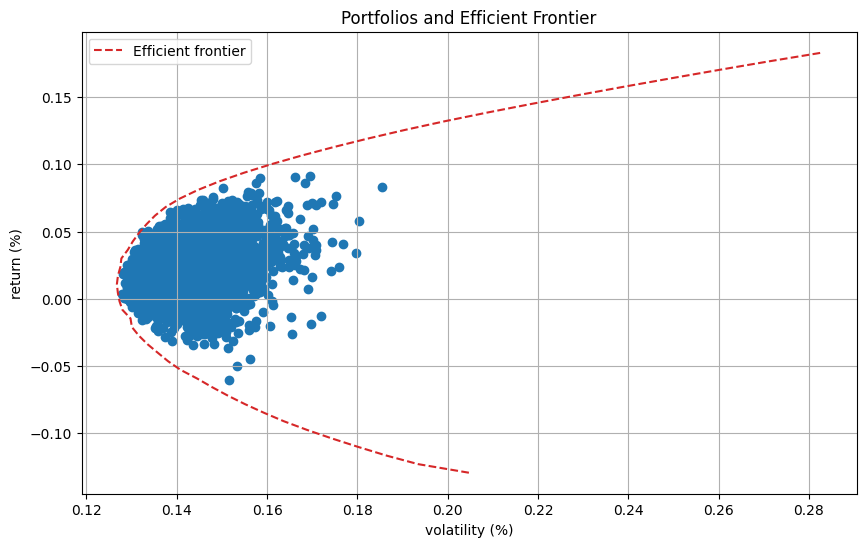

In [28]:
fig, ax = plt.subplots(1,1, figsize=(10,6)) 

im = ax.scatter(portfolios["volatility"], portfolios["return"])
ax.set_title("Portfolios and Efficient Frontier")
ax.set_ylabel("return (%)")
ax.grid()

# Draw the efficient frontier
df = efficient_frontier(50, daily_rets, cov_rets, periods_per_year)
df.plot.line(x="volatility", y="return", style="--", color="tab:red", ax=ax, grid=True, label="Efficient frontier")
# ax.set_xlim([0.25,0.453])
# ax.set_ylim([0.12,0.150])
ax.set_xlabel("volatility (%)")

plt.show()